# Simulator PV Valle_de_la_Luna_II

- Author: Victor Muñoz
- Collaborator: Nicolás Otárola
- Pvlib_version: 0.6.3
- Date : 06-01-2022 

In [19]:
# data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Photovoltaic systems
import pvlib
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain

# functions AND system photovoltaic
import sys
sys.path.append('../')

import funciones as func
import Valle_de_la_Luna_II as pv

import imp
imp.reload(pv)
imp.reload(func)

# save graphics
%matplotlib inline
%matplotlib notebook



## 1) Location , Module, Inverter, System and Model

In [20]:
#Location
loc = Location(latitude=pv.Location['lat'],
               longitude=pv.Location['long'],
               tz=pv.Location['tz'],
               altitude=pv.Location['alt'])

In [21]:
#module
module_325 = pd.Series(pv.JAM60S03,
                       name=pv.JAM60S03['Name'])

In [22]:
#inverter
inverter_1600_A = pd.Series(pv.MV_Power_Station_1600SC,
                            name=pv.MV_Power_Station_1600SC['Name'])
inverter_1600_B = pd.Series(pv.MV_Power_Station_1600SC,
                            name=pv.MV_Power_Station_1600SC['Name'])

In [23]:
#System
system_A = PVSystem(module_parameters=module_325,
                    inverter_parameters=inverter_1600_A,
                    surface_azimuth=pv.System['azimuth'],
                    surface_tilt=pv.System['tilt'],
                    modules_per_string=pv.System['m_p_s'],
                    strings_per_inverter=pv.System['s_p_i'])

system_B = PVSystem(module_parameters=module_325,
                    inverter_parameters=inverter_1600_B,
                    surface_azimuth=pv.System['azimuth'],
                    surface_tilt=pv.System['tilt'],
                    modules_per_string=pv.System['m_p_s'],
                    strings_per_inverter=pv.System['s_p_i'])

In [24]:
#model
mc_A = ModelChain(system_A, loc, 
                  aoi_model= 'physical' ,      # physical
                  spectral_model="no_loss",    # no_loss
                  dc_model='cec',              # cec or pvwatts
                  ac_model = 'pvwatts',        # snlinverter by pvwatts
                  temp_model='sapm',           # sapm
                  losses_model="pvwatts",      # pvwatts
                  name="system_A")             # system_A

mc_B = ModelChain(system_B, loc,
                  aoi_model="physical",        # physical
                  spectral_model="no_loss",    # no_loss
                  dc_model='cec',              # cec or pvwatts
                  ac_model = 'pvwatts',        # snlinverter by pvwatts
                  temp_model='sapm',           # sapm
                  losses_model="pvwatts",      # pvwatts
                  name="system_B")             # system_B

## 2) Data Weather Solcast and Generacion solar

In [25]:
# Weather Solcast
path = '../solcast/-25.406494_-70.480303_Solcast_PT60M.csv'
solcast = func.weather_solcast(path)
times, weather = func.get_times_weather(solcast,loc)

In [26]:
# Generacion solar

# Leer excel para generar pickle.
#name_excel = 'Generacion MWh plantas solar.xlsx'
#excel = pd.read_excel(name_excel)

# Leer picke una vez ya creado
data_pickle = pd.read_pickle('../Generacion MWh plantas solar')
name_pv = 'PMGD PFV VALLE DE LA LUNA II'
data_sub = data_pickle.loc[data_pickle['Central'] == name_pv]

In [42]:
data = func.filter_day_by_year(2020, data_sub)
data = [x*100 for x in data['Total']]

## 3) Simulate

In [43]:
# Run model
mc_A.run_model(times=times, weather=weather)
mc_B.run_model(times=times, weather=weather)

ModelChain: 
  name: system_B
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: pvwatts_inverter
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temp_model: sapm_temp
  losses_model: pvwatts_losses

## 4) Graphics

<IPython.core.display.Javascript object>


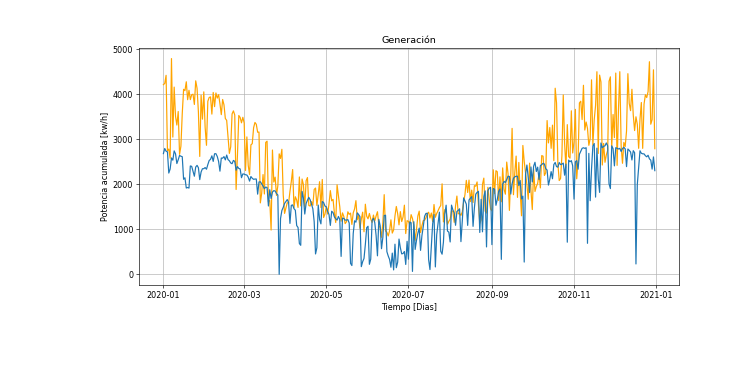

In [39]:
x_d ,y_d_a = func.get_daily_axes_from_modelChain_object(mc_A, 'System_A')
_ ,y_d_b = func.get_daily_axes_from_modelChain_object(mc_B, 'System_B')

y_d = [a+b for a,b in zip(y_d_a,y_d_b)]

func.plot(x=x_d,
          y=y_d,
          y2=data,
          size=(16,8),
          save='si',
          name_file='Valle_de_la_Luna_II_dias',
          color='orange',
          title='Generación',
          x_label='Tiempo [Dias]',
          y_label='Potencia acumulada [kw/h]')


In [ ]:
# falta modificar la data de entrda para que se grafique por hora
func.plot(x=mc_A.ac.iloc[0:].index,
          y=mc_A.ac.iloc[0:]['i_sc'].values,
          size=(16,8),
          save='si',
          name_file='Valle_de_la_Luna_II_horas',
          color='none',
          title='Generación',
          x_label='Tiempo [Horas]',
          y_label='Potencia acumulada [kw/h]')


In [ ]:
#falta modificar la data de entrada para que se grafique por hora
x_m, y_m_a = func.get_monthly_axes_from_modelChain_object(mc_A,'System_A')
_, y_m_b = func.get_monthly_axes_from_modelChain_object(mc_B,'System_B')

y_m = [a+b for a,b in zip(y_m_a,y_m_b)]

func.plot(x=x_m,
          y=y_m,
          size=(16,8),
          save='si',
          name_file='Valle_de_la_Luna_II_meses',
          color='red',
          title='Generación',
          x_label='Tiempo [Meses]',
          y_label='Potencia acumulada [kw/h]')


## Extra functions

In [31]:
textos_modulos = ['JA_Solar','325',''] # tienen que ser 3 textos
textos_inversores = ['1600','',''] # tiene que ser 3 textos
c = func.buscador(textos_inversores,textos_modulos)

for a in c:
    print(a,": ",c[a],"\n")

modulos_cec :  ['JA_Solar_Holding_JAP6_72_325_4BB', 'JA_Solar_Holdings_JAM6_k__72_325_4BB', 'JA_Solar_Holdings_JAP6_72_325_4BB', 'JA_Solar_Holdings_JAP6_72_325_4BB_RE', 'Shanghai_JA_Solar_Technology_JAM6_72_325_SI', 'Shanghai_JA_Solar_Technology_JAP6_72_325_3BB'] 

modulos_sandia :  [] 

inversores_cec :  ['Ingeteam_Power_Technology__Ingecon_Sun_1600TL_U_B615_Indoor__450V__450V__CEC_2018_', 'Ingeteam_Power_Technology__Ingecon_Sun_1600TL_U_B615_Outdoor__450V__450V__CEC_2018_', 'Power_Electronics__FS1600CU__400V__400V__CEC_2018_', 'Power_Electronics__FS1600CU15__645V__645V__CEC_2018_'] 

inversores_sandia :  ['Ingeteam_Power_Technology__Ingecon_Sun_1600TL_U_B615_Indoor__450V__450V__CEC_2018_', 'Ingeteam_Power_Technology__Ingecon_Sun_1600TL_U_B615_Outdoor__450V__450V__CEC_2018_', 'Power_Electronics__FS1600CU__400V__400V__CEC_2018_', 'Power_Electronics__FS1600CU15__645V__645V__CEC_2018_'] 



In [33]:
pvlib.pvsystem.retrieve_sam('cecinverter').Ingeteam_Power_Technology__Ingecon_Sun_1600TL_U_B615_Indoor__450V__450V__CEC_2018_

Vac          4.500000e+02
Paco         1.600000e+06
Pdco         1.625300e+06
Vdco         9.880000e+02
Pso          3.235010e+03
C0          -5.431050e-09
C1           1.370760e-05
C2           1.178140e-03
C3           7.015790e-04
Pnt          9.000000e+01
Vdcmax       1.110000e+03
Idcmax       1.645040e+03
Mppt_low     8.920000e+02
Mppt_high    1.110000e+03
Name: Ingeteam_Power_Technology__Ingecon_Sun_1600TL_U_B615_Indoor__450V__450V__CEC_2018_, dtype: float64